In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
import xarray as xr

Load the ENSO indices and upper ocean temperature spatial data we used for 2D convnets last time.

<xarray.Dataset>
Dimensions:  (lon: 72, lat: 23, time: 1236)
Coordinates:
  * lon      (lon) float32 0.25 5.25 10.25 15.25 ... 340.2 345.2 350.2 355.2
  * lat      (lat) float32 -54.75 -49.75 -44.75 -39.75 ... 45.25 50.25 55.25
  * time     (time) float64 -1.068e+03 -1.066e+03 -1.066e+03 ... 166.5 167.5
Data variables:
    temp     (time, lat, lon) float32 ...


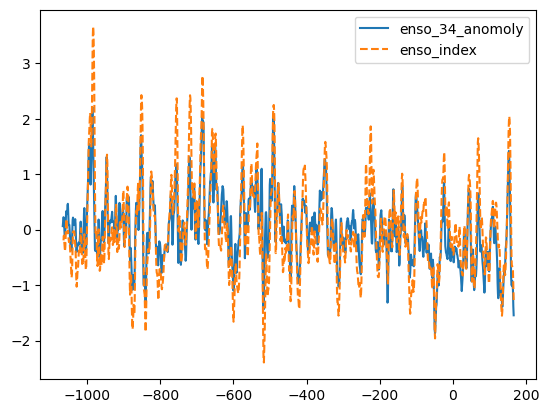

In [2]:
hc_ds = xr.open_dataset('hc.nc', decode_times=False)
print(hc_ds)
# load the data
with np.load('enso_and_pca.npz') as data:
    enso_index = data['y']  # 3-month-moving-averaged Nino3.4 index
    t_enso = data['t']  # months since jan. 1 1960 for the center of each 3-month window
t_enso = t_enso[1:]
enso_index = enso_index[1:]
ii_lon = np.logical_and(hc_ds.lon > 360 - 170, hc_ds.lon < 360-120)
ii_lat = np.logical_and(hc_ds.lat > -5, hc_ds.lat < 5)

t = hc_ds.time.values[1:-1]  # time axis for window centers enso 3.4 values
regional_temp_34 = hc_ds.temp[:, ii_lat, ii_lon].mean(axis=2).mean(axis=1).values  # spatial average
regional_temp_34 = (regional_temp_34[:-2] + regional_temp_34[1:-1] + regional_temp_34[2:]) / 3.0  # 3 month averages

month = np.remainder(np.round(t - 0.5).astype(int), 12)  # month index, january is zero

enso_34_climatology = np.array([regional_temp_34[month == m].mean() for m in range(12)])
enso_34_climatology_sd = np.array([regional_temp_34[month == m].std() for m in range(12)])
enso_34_anomoly = regional_temp_34.copy()
for m in range(12):
    enso_34_anomoly[month == m] -= enso_34_climatology[m]
plt.plot(t, enso_34_anomoly,'-', label='enso_34_anomoly')
plt.plot(t_enso, enso_index,'--', label='enso_index')
plt.legend()
plt.show()

Write a neural network class that predicts the ENSO index, uses 2D convolutions as well as fully connected layers, and optionally includes dropout and batchnorm for the hidden layers.

class Net(nn.module):
    def __init__(self, use_dropout=False, use_batchnorm=False):
        super(Net, self).__init__()
        ...

        return
    def forward(self, x):
        ...
        return x

In [20]:
1231*32*72

2836224

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ENSONet(nn.Module):
    def __init__(self, use_dropout=False, use_batchnorm=False):
        super(ENSONet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(32) if use_batchnorm else nn.Identity()
        self.bn2 = nn.BatchNorm2d(64) if use_batchnorm else nn.Identity()
        # Dropout layer
        self.dropout = nn.Dropout(0.5) if use_dropout else nn.Identity()
       # Calculate fc1 input size
        fc1_input_size = torch.tensor.__sizeof__(x)
        # Fully connected layers
        
        self.fc1 = nn.Linear(fc1_input_size, 128)  # Assuming input size of 32x32, adjust according to your input size
        self.fc2 = nn.Linear(128, 1)  # Output layer for ENSO index prediction

    def forward(self, x):
        # Apply first convolution, followed by batch norm, activation, and optional dropout
        x = self.dropout(F.relu(self.bn1(self.conv1(x))))
        # Apply max pooling
        x = F.max_pool2d(x, 2)
        # Apply second convolution, followed by batch norm, activation, and optional dropout
        x = self.dropout(F.relu(self.bn2(self.conv2(x))))
        # Apply max pooling
        x = F.max_pool2d(x, 2)
        # Flatten the output for the fully connected layer
        x = torch.flatten(x, 1)
        # Fully connected layer with relu activation and optional dropout
        x = self.dropout(F.relu(self.fc1(x)))
        # Output layer
        x = self.fc2(x)
        return x

Write a training loop as before, using an SGD optimizer, but now with the following new features:
* Do a random 70/20/10 split of training/validation/testing data. If you like, you can use `torch.utils.data.random_split`
* Calculate and store the loss averaged over the full validation dataset during training, once per epoch (recall that an epoch means training on the full training dataset once). Don't forget to use `with torch.no_grad()` when calculating the validation loss, and don't forget to call `model.eval()` before calculating it, and `model.train()` before going back to training afterwards.
* Stop the training if the validation loss fails to decrease for 5 consecutive epochs.
* Whenever the validation loss achieves a new best value so far, save the network parameters in a state_dict. At the end of training, check the validation loss one last time and revert to the best previous parameters if the previous state_dict gave a better validation loss. Remember to use `deepcopy` as described in the lecture.
* Save the results to disk. Verify that you can load them again and apply them to the trained network.

training_loss, validation_loss = [], []

for i in range(n_epochs):
    for batch in data_loader:
        ...
        training_loss.append(...)

    validation_loss.append(...)


In [4]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.optim import SGD
from torch.nn import MSELoss
from copy import deepcopy
hc=np.array(hc_ds.temp[:-5])
t=hc_ds.time[:-4]

X=torch.tensor(hc,dtype=torch.float32).unsqueeze(1)
y=torch.tensor(enso_index[1:],dtype=torch.float32).unsqueeze(1)
# Assuming X and y are your datasets as tensors
dataset = TensorDataset(X, y)

# Splitting the dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
model = ENSONet(use_dropout=True, use_batchnorm=True)
criterion = MSELoss()
optimizer = SGD(model.parameters(), lr=0.01)

# Training loop with new features
num_epochs = 100
best_val_loss = float('inf')
best_model_params = deepcopy(model.state_dict())
val_loss_increase_count = 0
training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        # Record training loss
        training_losses.append(loss.item())
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()
    val_loss /= len(val_loader)
    # Record validation loss
    validation_losses.append(val_loss)
    
    # Early stopping and best model saving
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_params = deepcopy(model.state_dict())
        val_loss_increase_count = 0  # reset counter
    else:
        val_loss_increase_count += 1
        if val_loss_increase_count >= 5:
            print(f'Stopping early at epoch {epoch+1}')
            break
    
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss}')

# Revert to the best model parameters if needed
final_model = ENSONet(use_dropout=True, use_batchnorm=True)
final_model.load_state_dict(best_model_params)

# Save the model state
torch.save(best_model_params, 'best_ensonet_model.pth')

# Example of loading
loaded_params = torch.load('best_ensonet_model.pth')
model_to_load = ENSONet(use_dropout=True, use_batchnorm=True)
model_to_load.load_state_dict(loaded_params)

# Now `model_to_load` is ready to be used for predictions or further training

Epoch 1, Validation Loss: 0.657553642988205
Epoch 2, Validation Loss: 0.6566333062946796
Epoch 3, Validation Loss: 0.6564192697405815
Epoch 4, Validation Loss: 0.656401727348566
Epoch 5, Validation Loss: 0.6564130745828152
Epoch 6, Validation Loss: 0.6564931534230709
Epoch 7, Validation Loss: 0.6565214619040489
Epoch 8, Validation Loss: 0.6565362364053726
Stopping early at epoch 9


<All keys matched successfully>

Plot the loss on the training and validation data as a function of the number of gradient steps taken so far. Keep in mind that the training loss is calculated more often on minibatches, so that `training_loss[i]` doesn't match `validation_loss[i]`, and the training loss will be noisier.

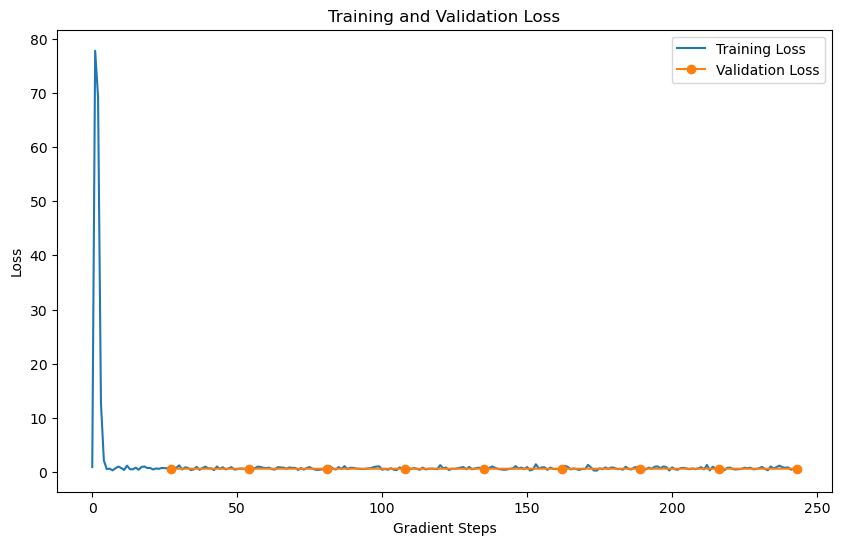

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
# For validation loss, plot against the number of steps per epoch
steps_per_epoch = len(train_loader)
epochs = range(1, len(validation_losses) + 1)
plt.plot([step * steps_per_epoch for step in epochs], validation_losses, label='Validation Loss', marker='o')
plt.xlabel('Gradient Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Try using batchnorm or dropout, and see the effect on your performance. Double check that you get the same output $\hat y$ from the network every time for a data point from the test set. If initial results don't look good, consider adjusting the learning rate and/or batch size.

In [8]:
import torch
from torch.optim import SGD
from torch.utils.data import DataLoader
from torch.nn.functional import cross_entropy
# Function to train and evaluate the model
def train_and_evaluate(use_dropout, use_batchnorm, learning_rate, batch_size):
    # Data loading and model setup omitted for brevity
    # ...
    model = ENSONet(use_dropout=use_dropout, use_batchnorm=use_batchnorm)
    optimizer = SGD(model.parameters(), lr=learning_rate)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    num_epochs = 10  # Example number of epochs
    
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_loss = 0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = cross_entropy(outputs, targets)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update model parameters
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
        

    # Consistency check
    model.eval()
    test_data_point = test_dataset[0][0].unsqueeze(0)  # Assuming the first data point
    with torch.no_grad():
        output1 = model(test_data_point)
        output2 = model(test_data_point)
    assert torch.allclose(output1, output2), "Outputs are not consistent"
    print(f"Outputs are consistent for use_dropout={use_dropout}, use_batchnorm={use_batchnorm}")


# Example usage
train_and_evaluate(use_dropout=False, use_batchnorm=False, learning_rate=0.01, batch_size=32)
train_and_evaluate(use_dropout=True, use_batchnorm=False, learning_rate=0.01, batch_size=32)
train_and_evaluate(use_dropout=False, use_batchnorm=True, learning_rate=0.01, batch_size=32)
train_and_evaluate(use_dropout=True, use_batchnorm=True, learning_rate=0.01, batch_size=32)


Epoch 1/10, Loss: 0.0000
Epoch 2/10, Loss: 0.0000
Epoch 3/10, Loss: 0.0000
Epoch 4/10, Loss: 0.0000
Epoch 5/10, Loss: 0.0000
Epoch 6/10, Loss: 0.0000
Epoch 7/10, Loss: 0.0000
Epoch 8/10, Loss: 0.0000
Epoch 9/10, Loss: 0.0000
Epoch 10/10, Loss: 0.0000
Outputs are consistent for use_dropout=False, use_batchnorm=False
Epoch 1/10, Loss: 0.0000
Epoch 2/10, Loss: 0.0000
Epoch 3/10, Loss: 0.0000
Epoch 4/10, Loss: 0.0000
Epoch 5/10, Loss: 0.0000
Epoch 6/10, Loss: 0.0000
Epoch 7/10, Loss: 0.0000
Epoch 8/10, Loss: 0.0000
Epoch 9/10, Loss: 0.0000
Epoch 10/10, Loss: 0.0000
Outputs are consistent for use_dropout=True, use_batchnorm=False
Epoch 1/10, Loss: 0.0000
Epoch 2/10, Loss: 0.0000
Epoch 3/10, Loss: 0.0000
Epoch 4/10, Loss: 0.0000
Epoch 5/10, Loss: 0.0000
Epoch 6/10, Loss: 0.0000
Epoch 7/10, Loss: 0.0000
Epoch 8/10, Loss: 0.0000
Epoch 9/10, Loss: 0.0000
Epoch 10/10, Loss: 0.0000
Outputs are consistent for use_dropout=False, use_batchnorm=True
Epoch 1/10, Loss: 0.0000
Epoch 2/10, Loss: 0.0000
E

Do some hyperparameter tuning: for at least two values of the learning rate, two values of the number of layers, two different optimizers, and using either dropout, batchnorm or neither, train your network on the training data, and evaluate performance on the validation set (that's at least 48 combinations!). Do your best to get results before the homework is due (remember you can use GPUs), but if it's taking too long just hand in what you have.

Write some code to test all these combinations instead of adjusting them manually or copy-pasting your training code.

For the hyperparameter settings with the best validation loss, evaluate performance on the test set.

In [28]:
import itertools
from torch.optim import SGD, Adam

# Define hyperparameters to test
learning_rates = [0.01, 0.001]
layer_configs = ['simple', 'deep']  # This will be interpreted in the model creation function
optimizers = [SGD, Adam]
dropout_batchnorm_configs = [(True, True), (False, False)]

# Function to create the model based on hyperparameters
def create_model(layer_config, use_dropout, use_batchnorm):
    class CustomENSONet(ENSONet):
        def __init__(self, layer_config, use_dropout, use_batchnorm):
            super().__init__(use_dropout, use_batchnorm)
            if layer_config == 'deep':
                # Add an additional convolutional layer
                self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
                self.bn3 = nn.BatchNorm2d(128) if use_batchnorm else nn.Identity()
                self.fc3 = nn.Linear(128, 1)  # Adjust the output layer
            

        def forward(self, x):
            if hasattr(self, 'conv3'):
                x = self.dropout(F.relu(self.bn3(self.conv3(x))))
                x = F.max_pool2d(x, 2)
            x = torch.flatten(x, 1)
            x = self.dropout(F.relu(self.fc1(x)))
            if hasattr(self, 'fc3'):
                x = self.dropout(F.relu(self.fc2(x)))
                x = self.fc3(x)
            else:
                x = self.fc2(x)
            return x

    return CustomENSONet(layer_config, use_dropout, use_batchnorm)

# Function to train the model and return validation loss
def train_and_evaluate_model(model, optimizer_class, learning_rate, train_loader, val_loader):
    model.train()  # Set model to training mode
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    num_epochs = 10  # Example number of epochs

    for epoch in range(num_epochs):
        total_train_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = cross_entropy(outputs, targets)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update model parameters
            total_train_loss += loss.item()

        # Validation phase
        model.eval()  # Set model to evaluation mode
        total_val_loss = 0
        with torch.no_grad():  # No gradient computation in validation phase
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = cross_entropy(outputs, targets)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)  # Calculate average validation loss

    return avg_val_loss  # Return average validation loss after all epochs

# Record of best performance
best_val_loss = float('inf')
best_config = None

# Iterate over all combinations
for lr, layer_config, optimizer_class, (use_dropout, use_batchnorm) in itertools.product(learning_rates, layer_configs, optimizers, dropout_batchnorm_configs):
    model = create_model(layer_config, use_dropout, use_batchnorm)
    avg_val_loss = train_and_evaluate_model(model, optimizer_class, lr, train_loader, val_loader)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_config = (lr, layer_config, optimizer_class.__name__, use_dropout, use_batchnorm)

# Train the final model with the best configuration
final_model = create_model(best_config[1], best_config[3], best_config[4])
# Use the best learning rate and optimizer from best_config
# Evaluate on the test set (this part is omitted for brevity)

print(f"Best configuration: {best_config} with validation loss: {best_val_loss}")

AttributeError: 'CustomENSONet' object has no attribute '_get_fc1_input_size'